In [1]:
# Import libraries
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader

In [2]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Import modules
from src.data.loader import ThermalDataLoader
from src.features.thermal import create_thermal_threshold_tensor
from src.features.edge_detection import create_edge_detection_tensors
from src.data.preprocessor import prepare_labels
from src.utils.visualization import (
    get_thermal_stats,
    print_thermal_stats,
    visualize_thermal_sequence,
    get_edge_stats,
    print_edge_stats,
    visualize_edge_sequence,
    visualize_thermal_threshold_comparison,
    get_label_examples
)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Create absolute paths
base_directories = [
    os.path.join(project_root, 'data/input/Nublado'),
    os.path.join(project_root, 'data/input/Emisiones'),
    os.path.join(project_root, 'data/input/Despejado')
]

allowed_labels = {'Nublado', 'Emisiones', 'Despejado'}

In [6]:
# Initialize data loader
print("\nInitializing data loader...")
thermal_loader = ThermalDataLoader(
    base_directories=base_directories,
    limit_per_directory=4500,
    allowed_labels=allowed_labels
)


Initializing data loader...


In [7]:
# Create initial dataset
print("\nCreating dataset...")
dataset = thermal_loader.create_dataset()


Creating dataset...

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Nublado


Processing files in Nublado: 100%|██████████| 401/401 [00:05<00:00, 79.03it/s]



Successfully processed 401 files from Nublado

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Emisiones


Processing files in Emisiones:  41%|████      | 1417/3498 [00:15<00:24, 85.68it/s]

Skipping c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Emisiones\CTP_RUMHIR_20221206_0448.fff: All NaN values after correction


Processing files in Emisiones:  68%|██████▊   | 2388/3498 [00:28<00:15, 70.58it/s]

Skipping c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Emisiones\CTP_RUMHIR_20221221_0039.fff: All NaN values after correction


Processing files in Emisiones: 100%|██████████| 3498/3498 [00:43<00:00, 79.71it/s]



Problematic files summary:
  CTP_RUMHIR_20221206_0448.fff: Invalid or NaN image - skipped
  CTP_RUMHIR_20221221_0039.fff: Invalid or NaN image - skipped

Total skipped files: 2

Successfully processed 3496 files from Emisiones

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\input\Despejado


Processing files in Despejado: 100%|██████████| 3127/3127 [00:35<00:00, 87.57it/s]



Successfully processed 3127 files from Despejado

Finalizing dataset...

Creating tensors for 7024 images...
Image dimensions: 480x640
Estimated memory requirement: 16.08 GB

Allocating memory...

Processing batch 1/15

Processing batch 2/15

Processing batch 3/15

Processing batch 4/15

Processing batch 5/15

Processing batch 6/15

Processing batch 7/15

Processing batch 8/15

Processing batch 9/15

Processing batch 10/15

Processing batch 11/15

Processing batch 12/15

Processing batch 13/15

Processing batch 14/15

Processing batch 15/15


In [8]:
# Process the dataset
if dataset is not None:
    # Convert numpy arrays to PyTorch tensors and check for NaN
    print("\nConverting tensors...")
    corrected_tensor = torch.tensor(dataset['tensors']['corrected']).float()
    
    # Check for NaN values in corrected tensor
    if torch.isnan(corrected_tensor).any():
        print("Warning: NaN values found in corrected tensor!")
        print(f"Number of NaN values: {torch.isnan(corrected_tensor).sum().item()}")
        # Optional: Replace NaN with 0 or mean value
        corrected_tensor = torch.nan_to_num(corrected_tensor, nan=0.0)
    
    # Create all initial tensors
    print("\nCreating feature tensors...")
    
    # Create edge detection tensors
    print("- Creating edge detection tensors...")
    edge_detection_data = create_edge_detection_tensors(corrected_tensor)
    edge_tensor = torch.tensor(edge_detection_data['edge_tensor']).float()
    edge_features = torch.tensor(edge_detection_data['edge_features']).float()
    
    # Check edge tensors for NaN
    if torch.isnan(edge_tensor).any():
        print("Warning: NaN values found in edge tensor!")
        edge_tensor = torch.nan_to_num(edge_tensor, nan=0.0)
    
    if torch.isnan(edge_features).any():
        print("Warning: NaN values found in edge features!")
        edge_features = torch.nan_to_num(edge_features, nan=0.0)
    
    # Create threshold tensors
    print("- Creating threshold tensors...")
    threshold_data = create_thermal_threshold_tensor(corrected_tensor)
    
    # Check threshold tensors for NaN
    for name, tensor in threshold_data['tensors'].items():
        if torch.isnan(tensor).any():
            print(f"Warning: NaN values found in threshold tensor {name}!")
            threshold_data['tensors'][name] = torch.nan_to_num(tensor, nan=0.0)
    
    # Prepare labels
    print("\nPreparing labels...")
    labels_data = prepare_labels(dataset)
    
    # Create preprocessed dataset dictionary
    print("\nOrganizing preprocessed dataset...")
    preprocessed_dataset = {
        'tensors': {
            'corrected': corrected_tensor,  
            'edge': edge_tensor,
            'edge_features': edge_features,
            'threshold': threshold_data['tensors']
        },
        'metadata': dataset['metadata'],
        'labels': {
            'numeric_labels': labels_data['numeric_labels'],
            'label_mapping': labels_data['label_mapping']
        }
    }

    # Get project root path (up one level from notebooks)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    
    # Create processed directory in the correct location
    processed_dir = os.path.join(project_root, 'data', 'processed')
    os.makedirs(processed_dir, exist_ok=True)
    
    # Save the preprocessed dataset
    print("\nSaving preprocessed dataset...")
    preprocessed_dataset_path = os.path.join(processed_dir, 'preprocessed_dataset.pt')
    torch.save(preprocessed_dataset, preprocessed_dataset_path)
    print("Dataset saved successfully!")

    # Print shapes of saved tensors
    print("\nTensor shapes:")
    print(f"Corrected: {preprocessed_dataset['tensors']['corrected'].shape}")
    print(f"Edge: {preprocessed_dataset['tensors']['edge'].shape}")
    print("Threshold tensors:")
    for name, tensor in preprocessed_dataset['tensors']['threshold'].items():
        print(f"- {name}: {tensor.shape}")
    print(f"Labels: {preprocessed_dataset['labels']['numeric_labels'].shape}")


Converting tensors...

Creating feature tensors...
- Creating edge detection tensors...
- Creating threshold tensors...

Preparing labels...

Organizing preprocessed dataset...

Saving preprocessed dataset...
Dataset saved successfully!

Tensor shapes:
Corrected: torch.Size([480, 640, 7024])
Edge: torch.Size([480, 640, 7024])
Threshold tensors:
- low: torch.Size([480, 640, 7024])
- medium: torch.Size([480, 640, 7024])
- high: torch.Size([480, 640, 7024])
- very_high: torch.Size([480, 640, 7024])
Labels: torch.Size([7024])


Temperature Statistics:
Global min: -15.14°C
Global max: 23.78°C
Mean temperature: -1.61°C
Standard deviation: 6.25°C


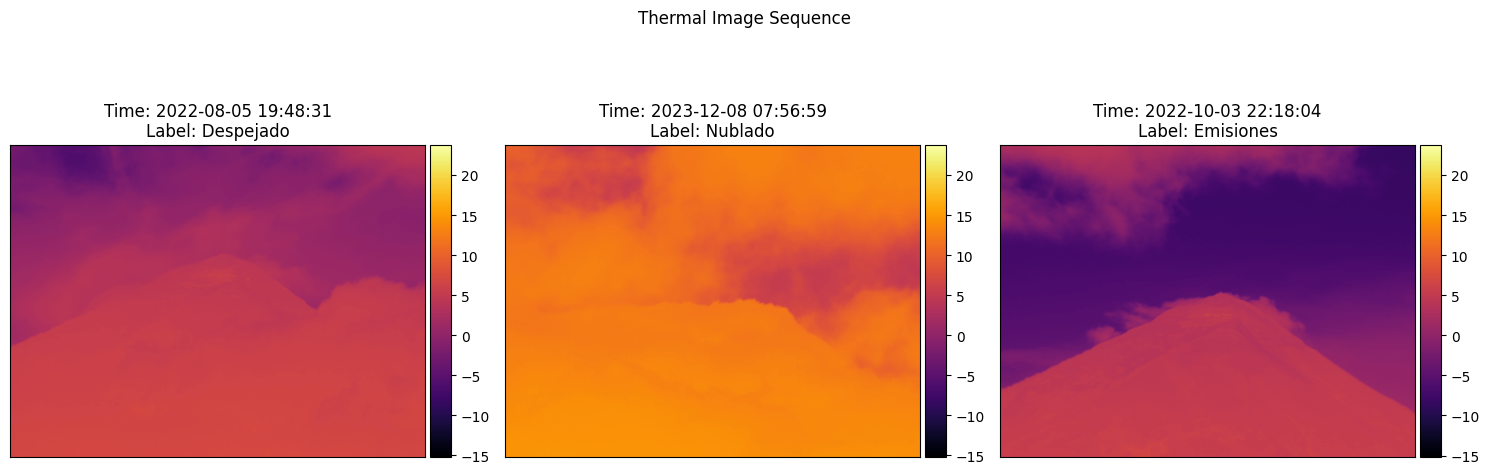

In [9]:
# Get necessary data from your dataset
timestamps = dataset['metadata']['timestamps']
numeric_labels = labels_data['numeric_labels']
label_mapping = labels_data['label_mapping']

# Get label examples and indices first
label_examples = get_label_examples(numeric_labels, label_mapping)
example_indices = list(label_examples.values())

# Then do the thermal visualization
thermal_stats = get_thermal_stats(corrected_tensor)
print_thermal_stats(thermal_stats)
visualize_thermal_sequence(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,
    thermal_stats['global_min'],
    thermal_stats['global_max'],
    label_mapping
)


Edge Detection Statistics:
Average edge density: 0.0065
Average total edges: 1987.45
Average non-zero ratio: 0.0065


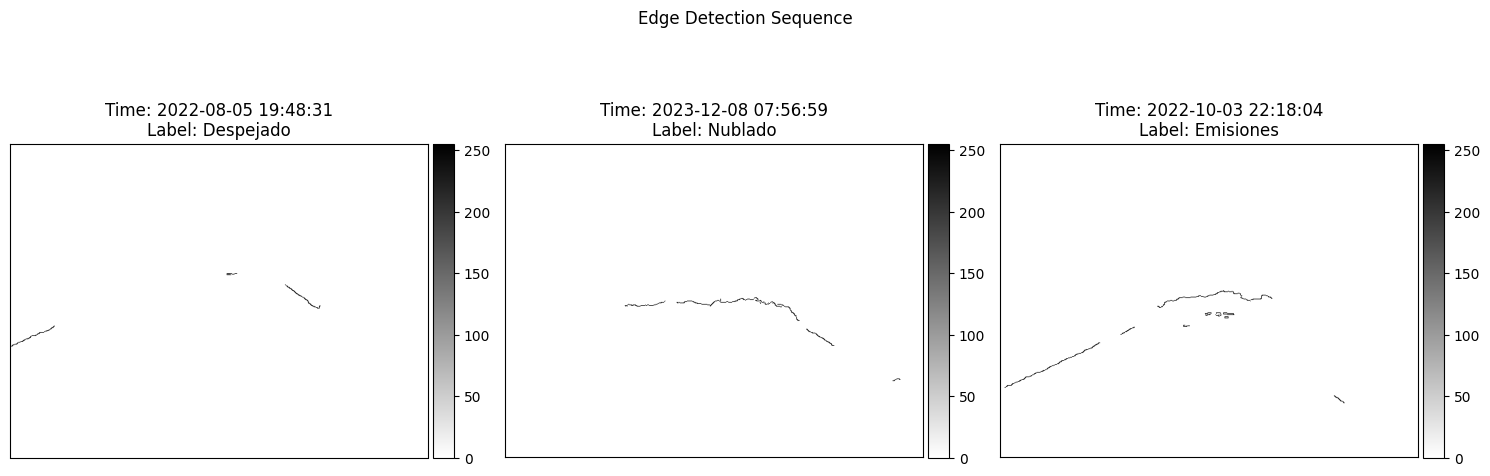

In [10]:
# Edge detection visualization and stats
edge_stats = get_edge_stats(edge_features)
print_edge_stats(edge_stats)
visualize_edge_sequence(
    edge_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices we created before
    label_mapping
)

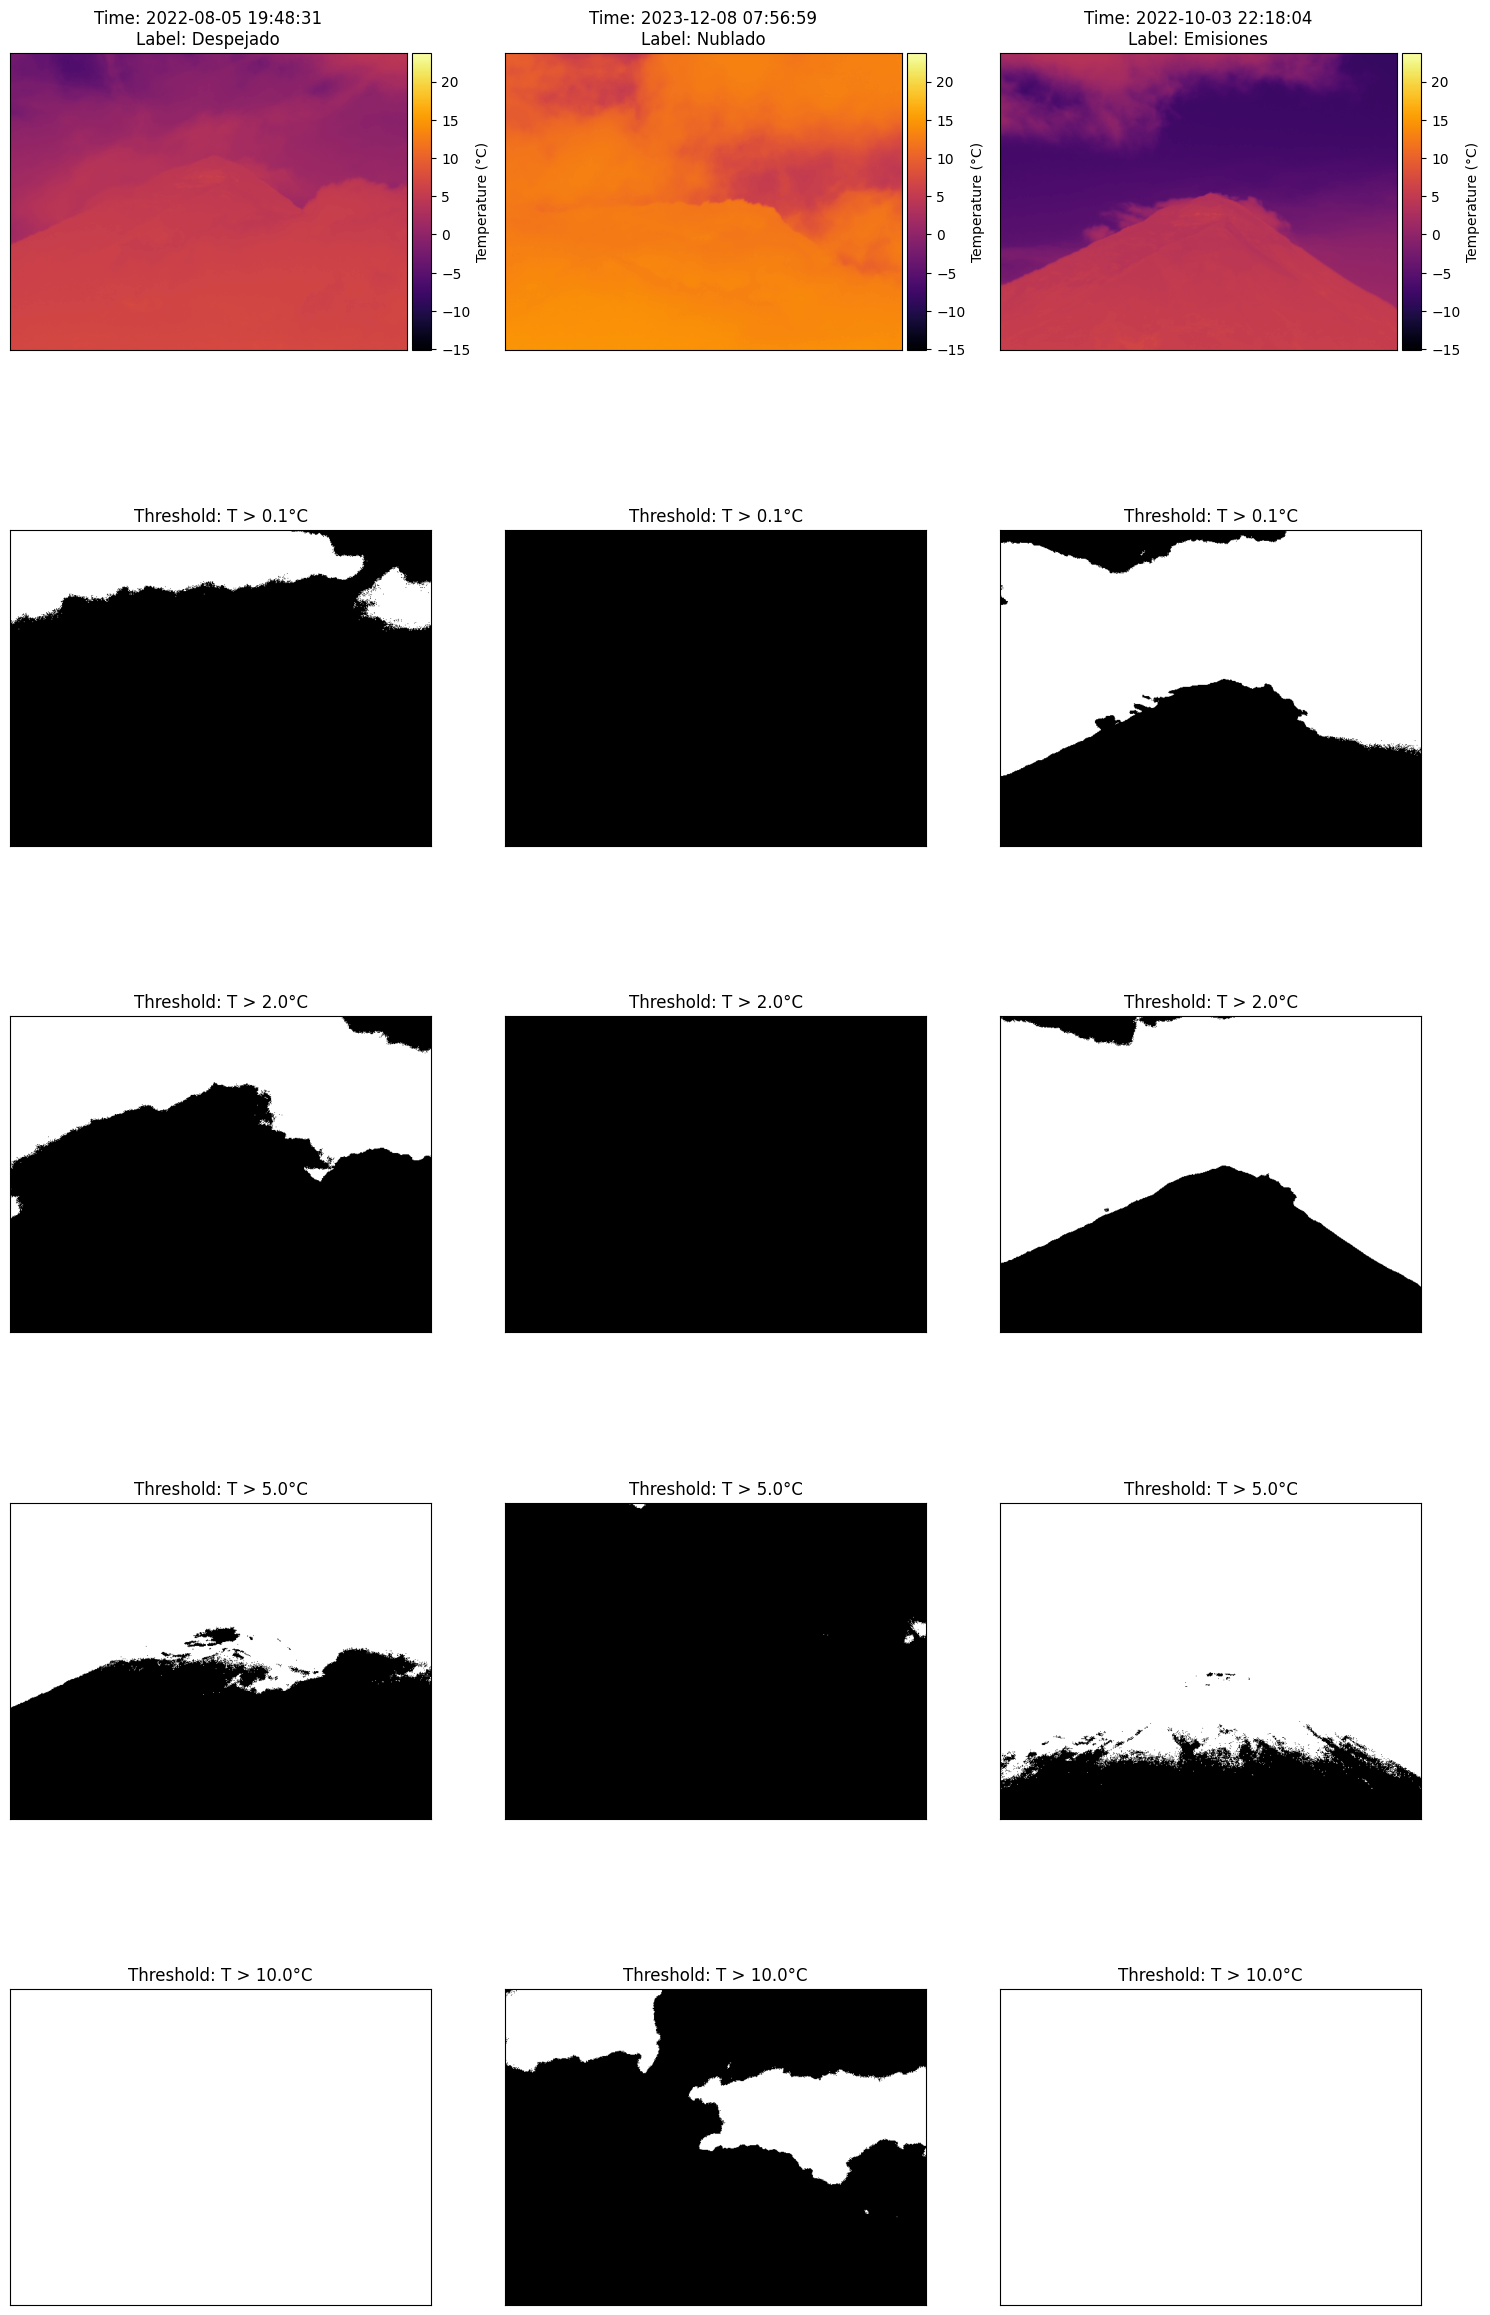

In [11]:
# Thermal threshold visualization
visualize_thermal_threshold_comparison(
    corrected_tensor,
    timestamps,
    numeric_labels,
    example_indices,  # Using the same example_indices from before
    label_mapping
)